In [7]:
import os
import time
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np
import pandas as pd
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, CuDNNLSTM
from keras.optimizers import Adam
from keras import backend as K
import time as t_lib
import tensorflow as tf
from threading import Thread
from IPython.display import clear_output
from matplotlib import pyplot

In [8]:
DATAFRAME_NAME = 'EURUSD_m15_Ask_ready.csv'
NUMBER_OF_SAMPLES = 50

EPISODES = 5000
TICQTY_MAX = 55000
HOLD_REWARD = -5000
OPEN_TRADE_REWARD = 0
CLOSING_TRADE_WITH_OPENING = 100  #20
DIVIDE_PRICE_UNDER_LOCAL_MINIMA = 1  #10
REWARD_FOR_PIPS = 10000
TIMES_FACTOR = 40 #10

ACTION_DECODE = {
    0: 0,
    1: 0.5,
    2: 1,
}


In [9]:
class Dataframe:

    def __init__(self):
        self._dataframe = self._load()[0:2000]
        self.__scaler = MinMaxScaler()

    @property
    def lenght(self):
        return len(self._dataframe.index) - NUMBER_OF_SAMPLES

    def get(self, sample_number):
        if sample_number > self.lenght or sample_number < 0:
            raise ValueError("Sample number out of range (0 - {self.lenght})")

        start_index = sample_number
        end_index = start_index + NUMBER_OF_SAMPLES

        df_sample = self._dataframe[start_index: end_index]

        last_open = df_sample.at[df_sample.index[-1], 'open']
        last_close = df_sample.at[df_sample.index[-1], 'close']

        df_sample = df_sample[['open', 'close', 'high', 'low', 'tickqty', 'hours', 'minutes']].values
        df_sample = self._scale(df_sample, start=0, end=4)
        return np.expand_dims(df_sample, axis=0), last_open, last_close

    @staticmethod
    def _load():
        """ Creating relative path and then loading the df_path """
        """
        df_path = os.path.join(os.path.dirname(os.path.abspath(__file__)) +
                               os.path.normpath(f'/dfs/{cfg.DATAFRAME_NAME}'))
        """
        df_path = './dfs/{}'.format(DATAFRAME_NAME)
        df = pd.read_csv(
            df_path,
            dtype={
                'datetime'
                'open': np.float32,
                'close': np.float32,
                'high': np.float32,
                'low': np.float32,
                'tickqty': np.float32,
            }
        )

        # df['hours']= pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S.%f').dt.hour / 24
        df['hours'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.hour / 24
        df['minutes'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.minute / 64
        df['tickqty'] = df['tickqty'] / TICQTY_MAX
        return df

    def _scale(self, array: np.ndarray, start: int, end: int):
        columns = array.T[start: end].T

        self.__scaler.fit(columns)
        scaled_cols = self.__scaler.transform(columns).T
        array.T[start:end] = scaled_cols
        return array

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.sample_memory = deque()
        
        self.gamma = 0.99  # discount rate
        
        self.epsilon = 0 # exploration rate
        self.epsilon_min = 0.0
        self.epsilon_decay = 1
        
        self.learning_rate = 0.000945
        self.learning_rate_decay = 0.99999
        self.learning_rate_min = 0.0001
        
        self.batch_size_samples = 500
        self.batch_size = batch_size
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    """Huber loss for Q Learning

    References: https://en.wikipedia.org/wiki/Huber_loss
                https://www.tensorflow.org/api_docs/python/tf/losses/huber_loss
    """

    def _huber_loss(self, y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond = K.abs(error) <= clip_delta

        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)

        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(CuDNNLSTM(units=50, return_sequences=True, input_shape=self.state_size))
        model.add(CuDNNLSTM(units=33, return_sequences=True))  
        model.add(CuDNNLSTM(units=22, return_sequences=True))
        model.add(CuDNNLSTM(units=15, return_sequences=True))
        model.add(CuDNNLSTM(units=10, return_sequences=True))
        model.add(CuDNNLSTM(units=7, return_sequences=True))
        model.add(CuDNNLSTM(units=5, return_sequences=True))
        model.add(CuDNNLSTM(units=3, return_sequences=False))

        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=self._huber_loss,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        self.sample_memory.append((state, action, reward, next_state, done))
    
    def train_from_iterations(self):
        while True:
            if len(self.sample_memory) != 0:
                state, action, reward, next_state, done = self.sample_memory.popleft()
                self.train(state, action, reward, next_state, done)

    def train(self, state, action, reward, next_state, done):
        target = self.model.predict(state, steps=1, verbose=0)
        if done and reward > 80 * TIMES_FACTOR:
            target[0][action] = reward
        else:
            # a = self.model.predict(next_state)[0]
            t = self.target_model.predict(next_state)[0]
            target[0][action] = reward + self.gamma * np.amax(t)
            # target[0][action] = reward + self.gamma * t[np.argmax(a)]
        self.model.fit(state, target, epochs=1, verbose=0)
        # print('done')

    def act(self, state):
        if not isinstance(state, np.ndarray):
            return 0

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size), True
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0]), False  # returns action

    def predict(self, state):
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0])  # returns action

    def replay(self):
        while True:
            minibatch = random.sample(self.memory, self.batch_size)
            for state, action, reward, next_state, done in minibatch:
                if not isinstance(state, np.ndarray):
                    continue
                
                self.train(state, action, reward, next_state, done)
                """
                target = self.model.predict(state, steps=1, verbose=0)
                if done and reward > 80 * TIMES_FACTOR:
                    target[0][action] = reward
                else:
                    # a = self.model.predict(next_state)[0]
                    t = self.target_model.predict(next_state)[0]
                    target[0][action] = reward + self.gamma * np.amax(t)
                    # target[0][action] = reward + self.gamma * t[np.argmax(a)]
                self.model.fit(state, target, epochs=1, verbose=0)
                """
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            else:
                self.epsilon = self.epsilon_min
            
            if self.learning_rate > self.learning_rate_min:
                self.learning_rate *= self.learning_rate_decay
            else:
                self.learning_rate = self.learning_rate_min
            # print('done')
    
    def set_learning_rate(self):
        K.set_value(self.model.optimizer.lr, self.learning_rate)  # set new lr
        K.set_value(self.target_model.optimizer.lr, self.learning_rate)  # set new lr

    def load(self, name):
        self.model.load_weights(name)
        self.model._make_predict_function()
        self.model._make_test_function()
        self.model._make_train_function()

        self.target_model.load_weights(name)
        self.target_model._make_predict_function()
        self.target_model._make_test_function()
        self.target_model._make_train_function()

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
class Trevor:
    POSITIVE_TIMES_REWARD = 0.00001
    NEGATIVE_TIMES_REWARD = 0.00001

    def __init__(self, df):
        self.df = df

        self.cursor = 0
        self.enter_price = 0
        self.local_max_price = 0

        self.last_action = 0

        self.closed_counter = 0
        self.total_reward = 0
        self.trade_counter = 0

        self.closed_counter_list = []

    def reset(self):
        self.cursor = 0
        self.enter_price = 0
        self.last_action = 0
        self.closed_counter = 0
        self.trade_counter = 0
        self.total_reward = 0
        # self.reset_closed_list()

        return self.step(0)[0]

    def step(self, action):
        sample, last_open, last_close = self.df.get(self.cursor)

        reward, closing_trade = self.__process_action(action=action, last_close=last_close)
        sample = self.__append_last_action(sample=sample, action=action, last_close=last_close)

        self.__increment_cursor()

        return sample, reward, closing_trade, ''

    def get_total_reward(self):
        return self.total_reward

    def reset_closed_list(self):
        self.closed_counter_list = []

    def plot(self, title):
        x = list(range(1, len(self.closed_counter_list) + 1))
        pyplot.plot(x, self.closed_counter_list)
        pyplot.title(str(title))
        pyplot.show()

    def __process_action(self, action, last_close):
        if action < 0 or action > 2:
            raise ValueError('Action have to be inrage (0 - 2) got {action}')

        closing_trade = False

        # """ CLOSING POSITION """
        if (self.last_action == 2 and action == 0) or (self.last_action == 1 and action == 0):
            reward = self.__close_trade(last_close=last_close)
            closing_trade = True

        # """ CLOSING POSITION AND GOING TO DIFFERENT POSITION """
        elif (self.last_action == 2 and action == 1) or (self.last_action == 1 and action == 2):
            reward = self.__close_trade(last_close=last_close) - CLOSING_TRADE_WITH_OPENING
            self.enter_price = last_close
            self.local_max_price = last_close
            closing_trade = True

        # """ HOLDING OPENED POSITION  """
        elif (self.last_action == 2 and action == 2) or (self.last_action == 1 and action == 1):
            if self.last_action == 2:
                if self.local_max_price < last_close:
                    reward = (last_close - self.enter_price) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (last_close - self.local_max_price) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close > self.enter_price \
                        else reward

            else:
                if self.local_max_price > last_close:
                    reward = (self.enter_price - last_close) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (self.local_max_price - last_close) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close < self.enter_price \
                        else reward

        # """ OPENING POSITION  """
        elif (self.last_action == 0 and action == 1) or (self.last_action == 0 and action == 2):
            self.enter_price = last_close
            self.local_max_price = last_close
            reward = OPEN_TRADE_REWARD

        # """ HOLD """
        elif self.last_action == 0 and action == 0:
            reward = HOLD_REWARD

        else:
            raise ValueError('Last action = {self.last_action} and actual_action = {action}')

        self.last_action = action
        self.total_reward += reward
        return reward, closing_trade

    def __increment_cursor(self):
        """ Incrementing the cursor, if the cursor is bigger than lenght of the dataframe, then reset it"""

        self.cursor += 1
        if self.cursor > self.df.lenght:
            self.cursor = 0

    def __close_trade(self, last_close):
        if self.last_action == 2:
            reward = (last_close - self.enter_price) * REWARD_FOR_PIPS * TIMES_FACTOR
            self.closed_counter += reward / TIMES_FACTOR
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        else:
            reward = (self.enter_price - last_close) * REWARD_FOR_PIPS * TIMES_FACTOR
            self.closed_counter += reward / TIMES_FACTOR
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        self.closed_counter_list.append(self.closed_counter)
        self.trade_counter += 1
        return reward

    def __append_last_action(self, sample: np.ndarray, action: int, last_close: float):
        how_many = sample.shape[1]
        decoded_action = ACTION_DECODE[action]

        action_arr = (np.expand_dims(np.asarray([decoded_action for i in range(0, how_many)]), axis=1))

        if action == 2 or action == 1:
            dif = (last_close - self.enter_price)
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        else:
            dif = 0
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        sample = np.append(sample[0], action_arr, axis=1)
        sample = np.append(sample, pip_difference, axis=1)

        return np.expand_dims(sample, axis=0)

More than 80 on candle 422
More than 80 on candle 1024
More than 80 on candle 1208
More than 80 on candle 1924


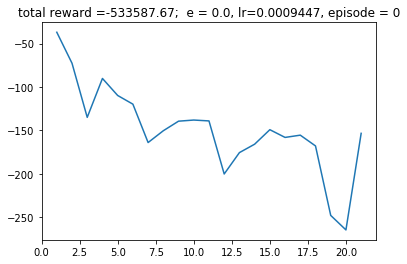

Waiting to train the whole dataset
action0:  143 
action1:  668 
action2:  1139
DONE, lets roll!!
247.379
More than 80 on candle 141
More than 80 on candle 389
More than 80 on candle 549
More than 80 on candle 875
More than 80 on candle 1584
More than 80 on candle 1867


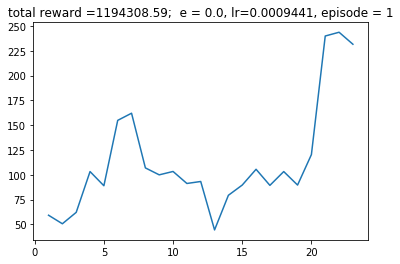

Waiting to train the whole dataset
action0:  26 
action1:  606 
action2:  1318
DONE, lets roll!!
349.862
More than 80 on candle 126
More than 80 on candle 438
More than 80 on candle 910
More than 80 on candle 1589
More than 80 on candle 1858


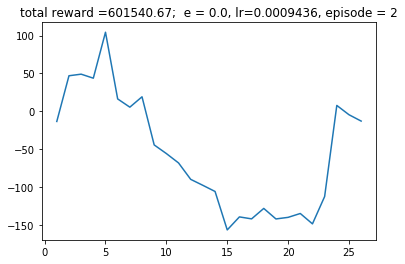

Waiting to train the whole dataset
action0:  26 
action1:  613 
action2:  1311
DONE, lets roll!!
353.208
More than 80 on candle 143
More than 80 on candle 393
More than 80 on candle 558
More than 80 on candle 1603
More than 80 on candle 1788


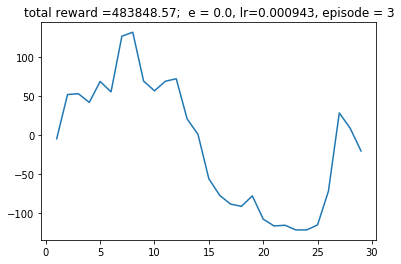

Waiting to train the whole dataset
action0:  35 
action1:  545 
action2:  1370
DONE, lets roll!!
356.402
More than 80 on candle 156
More than 80 on candle 413
More than 80 on candle 575
More than 80 on candle 907
More than 80 on candle 1071
More than 80 on candle 1596
More than 80 on candle 1870


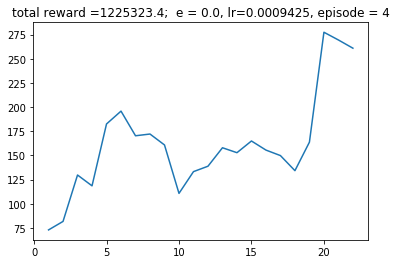

Waiting to train the whole dataset
action0:  29 
action1:  486 
action2:  1435
DONE, lets roll!!
348.566
More than 80 on candle 140
More than 80 on candle 387
More than 80 on candle 627
More than 80 on candle 1919


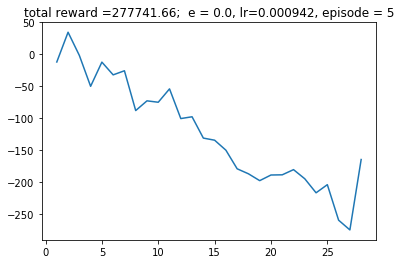

Waiting to train the whole dataset
action0:  38 
action1:  696 
action2:  1216
DONE, lets roll!!
359.488
More than 80 on candle 97
More than 80 on candle 409
More than 80 on candle 584
More than 80 on candle 910
More than 80 on candle 1064
More than 80 on candle 1815


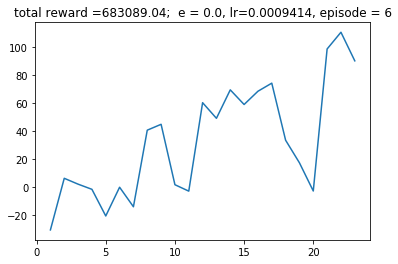

Waiting to train the whole dataset
action0:  35 
action1:  678 
action2:  1237
DONE, lets roll!!
361.136
More than 80 on candle 24
More than 80 on candle 116
More than 80 on candle 377
More than 80 on candle 559
More than 80 on candle 1578
More than 80 on candle 1848


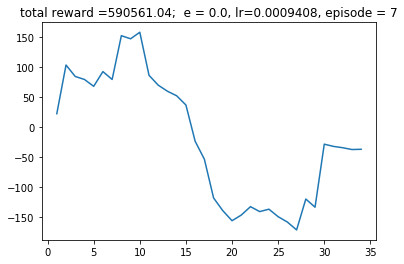

Waiting to train the whole dataset
action0:  55 
action1:  614 
action2:  1281
DONE, lets roll!!
361.551
More than 80 on candle 86
More than 80 on candle 394
More than 80 on candle 587
More than 80 on candle 1942


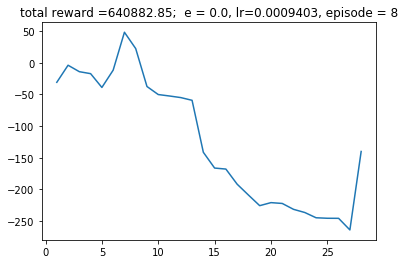

Waiting to train the whole dataset
action0:  36 
action1:  500 
action2:  1414
DONE, lets roll!!
358.689
More than 80 on candle 154
More than 80 on candle 370
More than 80 on candle 557
More than 80 on candle 1598
More than 80 on candle 1860


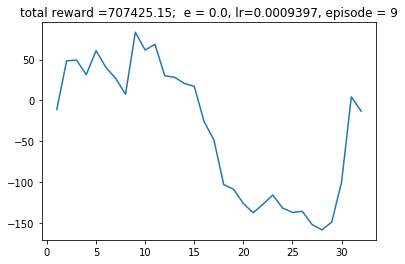

Waiting to train the whole dataset
action0:  64 
action1:  612 
action2:  1274
DONE, lets roll!!
361.755
More than 80 on candle 120
More than 80 on candle 553
More than 80 on candle 603
More than 80 on candle 874
More than 80 on candle 1556
More than 80 on candle 1883


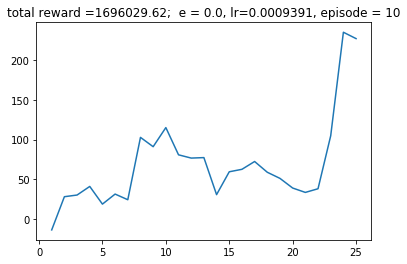

Waiting to train the whole dataset
action0:  38 
action1:  440 
action2:  1472
DONE, lets roll!!
355.993
More than 80 on candle 152
More than 80 on candle 460
More than 80 on candle 571
More than 80 on candle 978
More than 80 on candle 1082
More than 80 on candle 1922


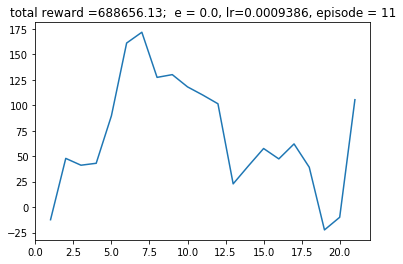

Waiting to train the whole dataset
action0:  47 
action1:  540 
action2:  1363
DONE, lets roll!!
356.227
More than 80 on candle 147
More than 80 on candle 401
More than 80 on candle 583
More than 80 on candle 1595
More than 80 on candle 1867


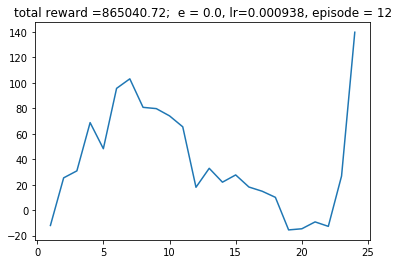

Waiting to train the whole dataset
action0:  29 
action1:  444 
action2:  1477
DONE, lets roll!!
341.836
More than 80 on candle 217
More than 80 on candle 423
More than 80 on candle 569
More than 80 on candle 1885


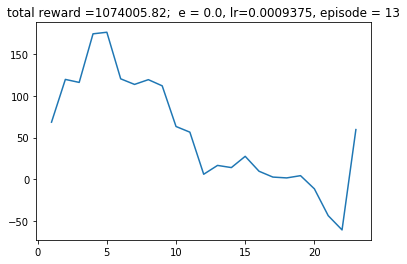

Waiting to train the whole dataset
action0:  36 
action1:  461 
action2:  1453
DONE, lets roll!!
354.829
More than 80 on candle 85
More than 80 on candle 383
More than 80 on candle 771
More than 80 on candle 1592
More than 80 on candle 1784


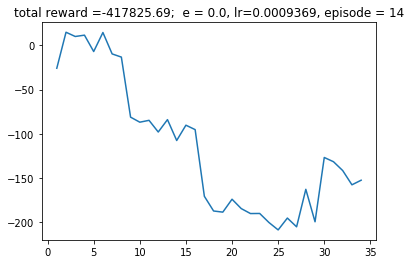

Waiting to train the whole dataset
action0:  44 
action1:  798 
action2:  1108
DONE, lets roll!!
350.715
More than 80 on candle 113
More than 80 on candle 385
More than 80 on candle 906
More than 80 on candle 1920


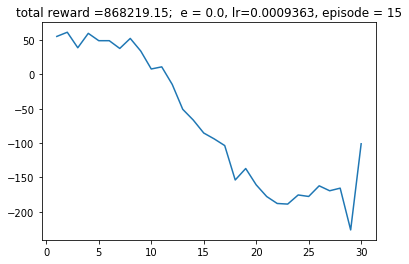

Waiting to train the whole dataset
action0:  44 
action1:  498 
action2:  1408
DONE, lets roll!!
352.245
More than 80 on candle 113
More than 80 on candle 399
More than 80 on candle 588
More than 80 on candle 851
More than 80 on candle 1556
More than 80 on candle 1880


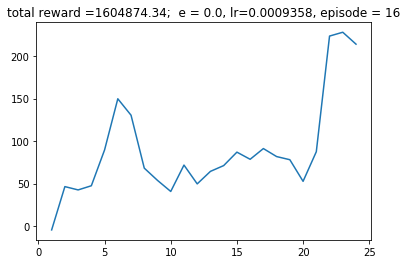

Waiting to train the whole dataset
action0:  31 
action1:  578 
action2:  1341
DONE, lets roll!!
346.445
More than 80 on candle 93
More than 80 on candle 374
More than 80 on candle 556
More than 80 on candle 902
More than 80 on candle 1554
More than 80 on candle 1879


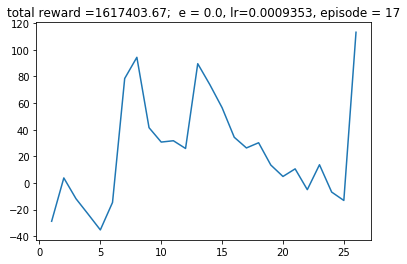

Waiting to train the whole dataset
action0:  54 
action1:  733 
action2:  1163
DONE, lets roll!!
349.349
More than 80 on candle 122
More than 80 on candle 387
More than 80 on candle 567
More than 80 on candle 813
More than 80 on candle 874
More than 80 on candle 1925


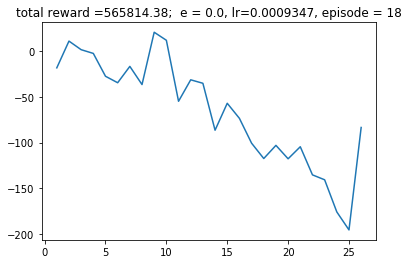

Waiting to train the whole dataset
action0:  26 
action1:  694 
action2:  1230
DONE, lets roll!!
341.427
More than 80 on candle 118
More than 80 on candle 383
More than 80 on candle 1591
More than 80 on candle 1856


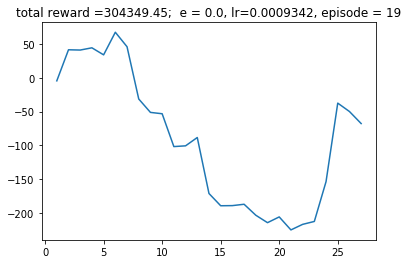

Waiting to train the whole dataset
action0:  30 
action1:  644 
action2:  1276
DONE, lets roll!!
353.314
More than 80 on candle 121
More than 80 on candle 423
More than 80 on candle 574
More than 80 on candle 874
More than 80 on candle 1592
More than 80 on candle 1884


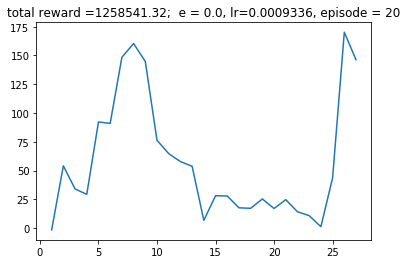

Waiting to train the whole dataset
action0:  44 
action1:  484 
action2:  1422
DONE, lets roll!!
357.284
More than 80 on candle 123
More than 80 on candle 177
More than 80 on candle 209
More than 80 on candle 910
More than 80 on candle 1068
More than 80 on candle 1591
More than 80 on candle 1865


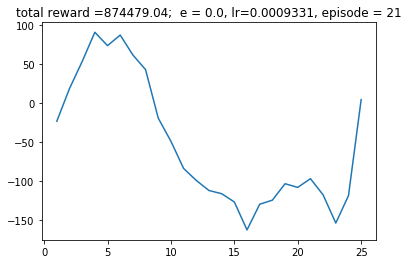

Waiting to train the whole dataset
action0:  40 
action1:  784 
action2:  1126
DONE, lets roll!!
342.361
More than 80 on candle 139
More than 80 on candle 876
More than 80 on candle 1378
More than 80 on candle 1796


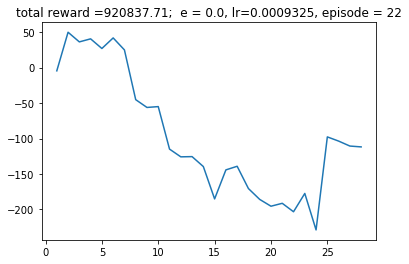

Waiting to train the whole dataset
action0:  28 
action1:  588 
action2:  1334
DONE, lets roll!!
348.185
More than 80 on candle 94
More than 80 on candle 418
More than 80 on candle 1867


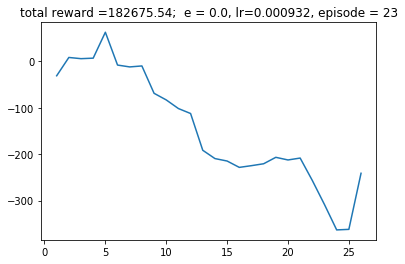

Waiting to train the whole dataset
action0:  23 
action1:  675 
action2:  1252
DONE, lets roll!!
344.384
More than 80 on candle 122
More than 80 on candle 581
More than 80 on candle 1558
More than 80 on candle 1916


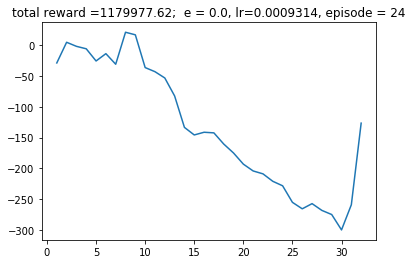

Waiting to train the whole dataset
action0:  46 
action1:  555 
action2:  1349
DONE, lets roll!!
344.117
More than 80 on candle 148
More than 80 on candle 580
More than 80 on candle 1891


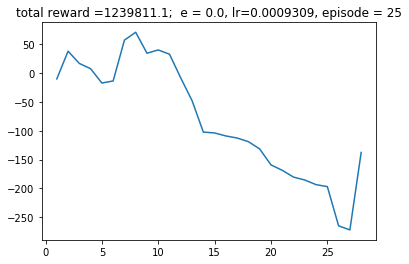

Waiting to train the whole dataset
action0:  32 
action1:  458 
action2:  1460
DONE, lets roll!!
347.65
More than 80 on candle 433
More than 80 on candle 486
More than 80 on candle 1924


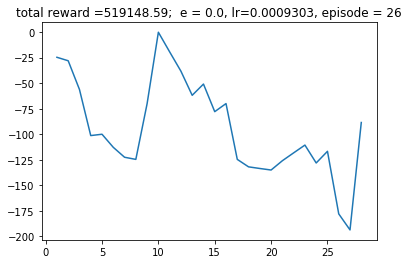

Waiting to train the whole dataset
action0:  35 
action1:  590 
action2:  1325
DONE, lets roll!!
348.993
More than 80 on candle 189
More than 80 on candle 417
More than 80 on candle 602
More than 80 on candle 1933


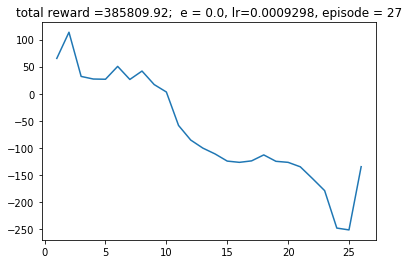

Waiting to train the whole dataset
action0:  25 
action1:  430 
action2:  1495
DONE, lets roll!!
353.616
More than 80 on candle 123
More than 80 on candle 402
More than 80 on candle 575
More than 80 on candle 1066
More than 80 on candle 1378
More than 80 on candle 1885


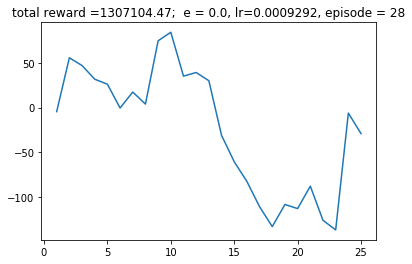

Waiting to train the whole dataset
action0:  40 
action1:  494 
action2:  1416
DONE, lets roll!!
348.639
More than 80 on candle 123
More than 80 on candle 391
More than 80 on candle 482
More than 80 on candle 1856


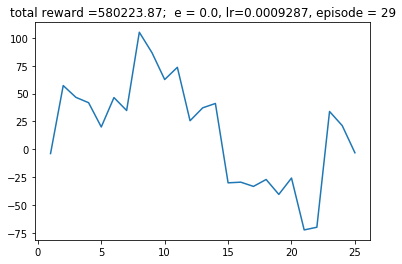

Waiting to train the whole dataset
action0:  23 
action1:  677 
action2:  1250
DONE, lets roll!!
354.453
More than 80 on candle 117
More than 80 on candle 580
More than 80 on candle 1936


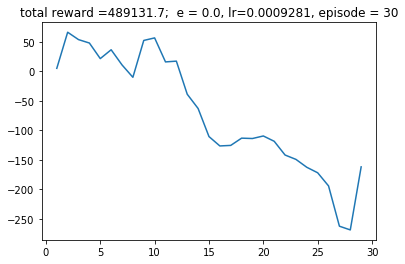

Waiting to train the whole dataset
action0:  21 
action1:  432 
action2:  1497
DONE, lets roll!!
347.364
More than 80 on candle 145
More than 80 on candle 414
More than 80 on candle 874
More than 80 on candle 1857


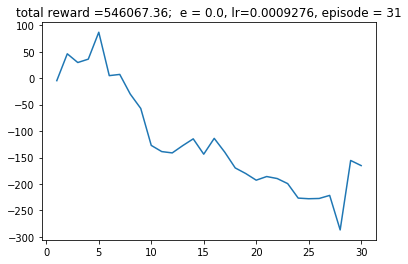

Waiting to train the whole dataset
action0:  49 
action1:  493 
action2:  1408
DONE, lets roll!!
351.981
More than 80 on candle 119
More than 80 on candle 389
More than 80 on candle 562
More than 80 on candle 1312
More than 80 on candle 1589
More than 80 on candle 1865


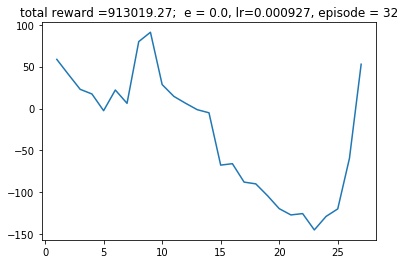

Waiting to train the whole dataset
action0:  39 
action1:  592 
action2:  1319
DONE, lets roll!!
346.416
More than 80 on candle 120
More than 80 on candle 387
More than 80 on candle 571
More than 80 on candle 1591
More than 80 on candle 1888


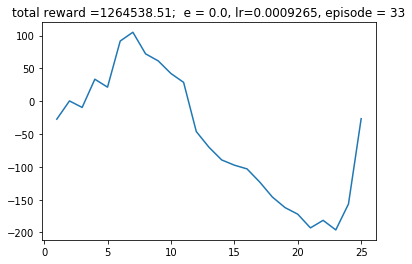

Waiting to train the whole dataset
action0:  23 
action1:  567 
action2:  1360
DONE, lets roll!!
347.455
More than 80 on candle 406
More than 80 on candle 565
More than 80 on candle 1805


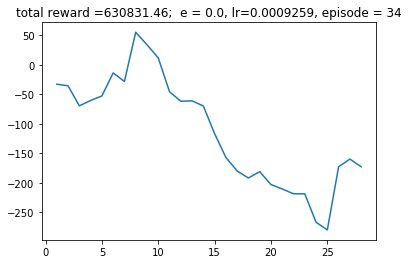

Waiting to train the whole dataset
action0:  34 
action1:  617 
action2:  1299
DONE, lets roll!!
351.935
More than 80 on candle 213
More than 80 on candle 621
More than 80 on candle 740
More than 80 on candle 875
More than 80 on candle 1925


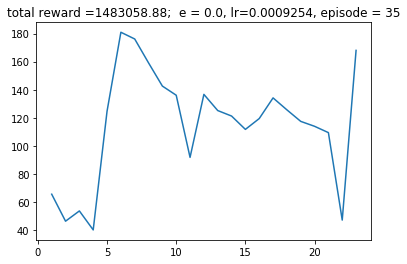

Waiting to train the whole dataset
action0:  36 
action1:  410 
action2:  1504
DONE, lets roll!!
349.601
More than 80 on candle 462
More than 80 on candle 578
More than 80 on candle 764
More than 80 on candle 876
More than 80 on candle 1059
More than 80 on candle 1877


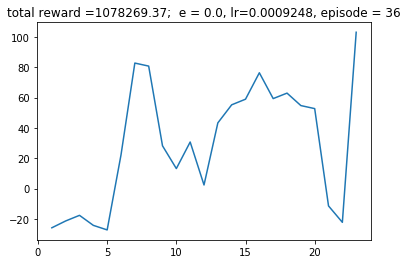

Waiting to train the whole dataset
action0:  32 
action1:  411 
action2:  1507
DONE, lets roll!!
357.884
More than 80 on candle 154
More than 80 on candle 406
More than 80 on candle 582
More than 80 on candle 1870


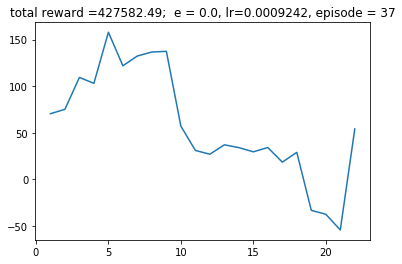

Waiting to train the whole dataset
action0:  45 
action1:  555 
action2:  1350
DONE, lets roll!!
342.621
More than 80 on candle 93
More than 80 on candle 557
More than 80 on candle 613
More than 80 on candle 874
More than 80 on candle 1591
More than 80 on candle 1861


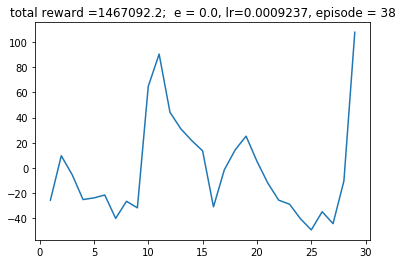

Waiting to train the whole dataset
action0:  22 
action1:  746 
action2:  1182
DONE, lets roll!!
361.419
More than 80 on candle 85
More than 80 on candle 441
More than 80 on candle 906
More than 80 on candle 1882


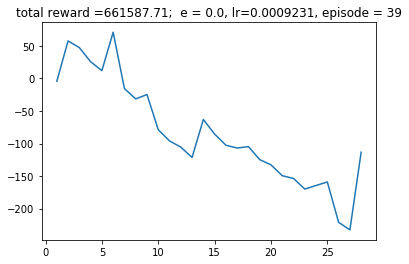

Waiting to train the whole dataset
action0:  26 
action1:  687 
action2:  1237
DONE, lets roll!!
347.743
More than 80 on candle 153
More than 80 on candle 417
More than 80 on candle 601
More than 80 on candle 737
More than 80 on candle 911
More than 80 on candle 1933


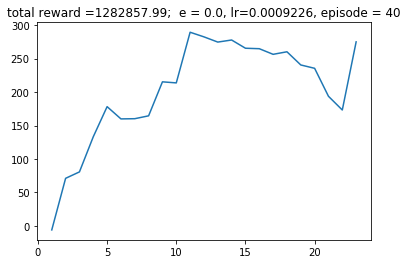

Waiting to train the whole dataset
action0:  28 
action1:  577 
action2:  1345
DONE, lets roll!!
346.237
More than 80 on candle 98
More than 80 on candle 368
More than 80 on candle 557
More than 80 on candle 906
More than 80 on candle 1883


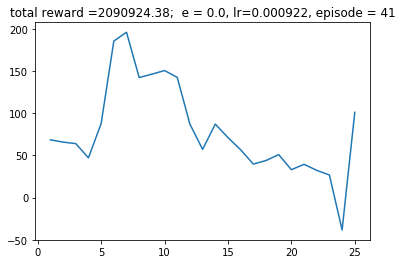

Waiting to train the whole dataset
action0:  21 
action1:  556 
action2:  1373
DONE, lets roll!!
349.332
More than 80 on candle 192
More than 80 on candle 406
More than 80 on candle 602
More than 80 on candle 915
More than 80 on candle 1903


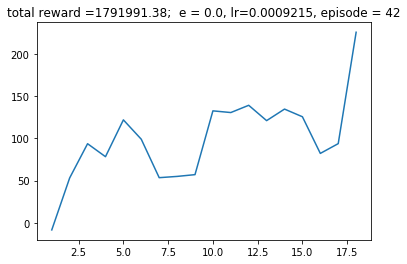

Waiting to train the whole dataset
action0:  16 
action1:  579 
action2:  1355
DONE, lets roll!!
354.046
More than 80 on candle 94
More than 80 on candle 424
More than 80 on candle 1487
More than 80 on candle 1607
More than 80 on candle 1854


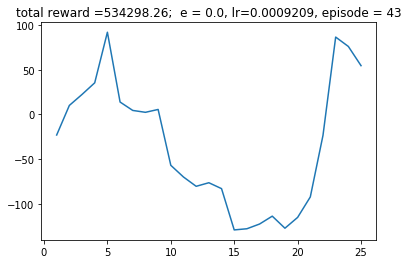

Waiting to train the whole dataset
action0:  27 
action1:  725 
action2:  1198
DONE, lets roll!!
350.878
More than 80 on candle 85
More than 80 on candle 406
More than 80 on candle 573
More than 80 on candle 907
More than 80 on candle 1869


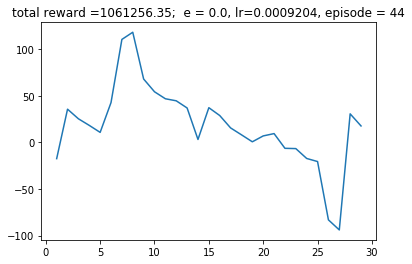

Waiting to train the whole dataset
action0:  50 
action1:  507 
action2:  1393
DONE, lets roll!!
356.802
More than 80 on candle 122
More than 80 on candle 401
More than 80 on candle 1071
More than 80 on candle 1490
More than 80 on candle 1613
More than 80 on candle 1878


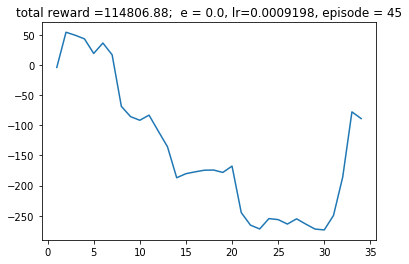

Waiting to train the whole dataset
action0:  35 
action1:  670 
action2:  1245
DONE, lets roll!!
353.334
More than 80 on candle 123
More than 80 on candle 378
More than 80 on candle 584
More than 80 on candle 907
More than 80 on candle 1586
More than 80 on candle 1884


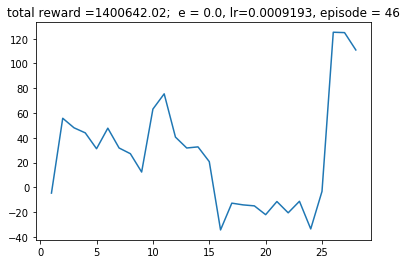

Waiting to train the whole dataset
action0:  9 
action1:  532 
action2:  1409
DONE, lets roll!!
361.61
More than 80 on candle 24
More than 80 on candle 116
More than 80 on candle 179
More than 80 on candle 201
More than 80 on candle 569
More than 80 on candle 734
More than 80 on candle 901
More than 80 on candle 1557
More than 80 on candle 1886


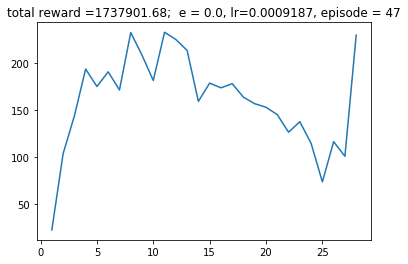

Waiting to train the whole dataset
action0:  44 
action1:  876 
action2:  1030
DONE, lets roll!!
360.421
More than 80 on candle 91
More than 80 on candle 392
More than 80 on candle 597
More than 80 on candle 1453
More than 80 on candle 1886


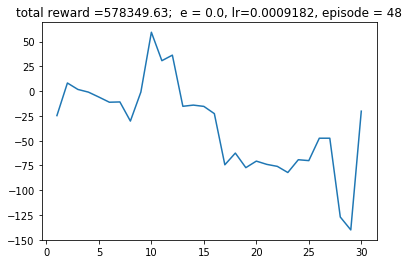

Waiting to train the whole dataset
action0:  37 
action1:  678 
action2:  1235
DONE, lets roll!!
358.323
More than 80 on candle 89
More than 80 on candle 389
More than 80 on candle 581
More than 80 on candle 1889


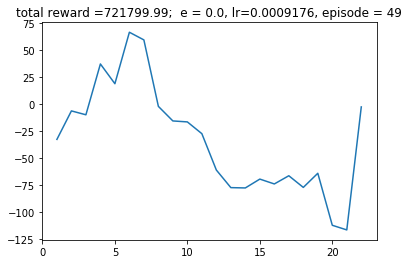

Waiting to train the whole dataset
action0:  17 
action1:  622 
action2:  1311
DONE, lets roll!!
356.78
More than 80 on candle 419
More than 80 on candle 1599
More than 80 on candle 1867


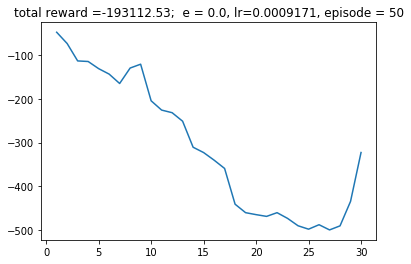

Waiting to train the whole dataset
action0:  42 
action1:  523 
action2:  1385
DONE, lets roll!!
358.147
More than 80 on candle 190
More than 80 on candle 390
More than 80 on candle 600
More than 80 on candle 746
More than 80 on candle 912
More than 80 on candle 1071
More than 80 on candle 1376
More than 80 on candle 1866


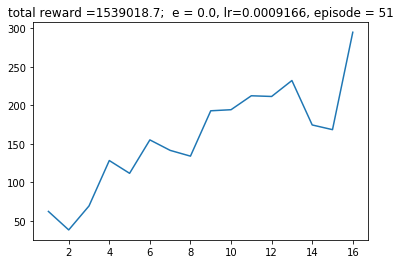

Waiting to train the whole dataset
action0:  26 
action1:  602 
action2:  1322
DONE, lets roll!!
349.495
More than 80 on candle 90
More than 80 on candle 176
More than 80 on candle 195
More than 80 on candle 1867


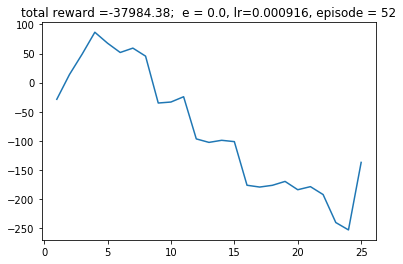

Waiting to train the whole dataset
action0:  41 
action1:  677 
action2:  1232
DONE, lets roll!!
351.246
More than 80 on candle 122
More than 80 on candle 1398


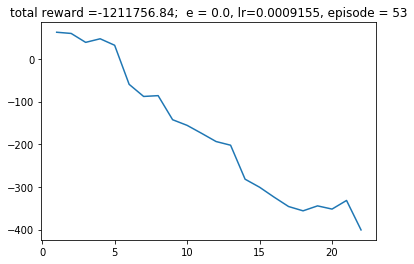

Waiting to train the whole dataset
action0:  34 
action1:  499 
action2:  1417
DONE, lets roll!!
361.59
More than 80 on candle 151
More than 80 on candle 385
More than 80 on candle 586
More than 80 on candle 903
More than 80 on candle 1853


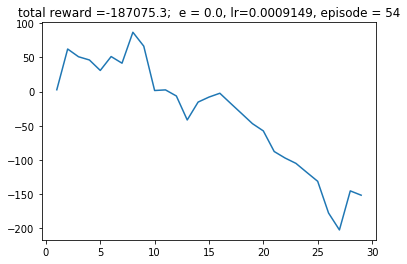

Waiting to train the whole dataset
action0:  42 
action1:  409 
action2:  1499
DONE, lets roll!!
364.42
More than 80 on candle 120
More than 80 on candle 400
More than 80 on candle 486
More than 80 on candle 979
More than 80 on candle 1093
More than 80 on candle 1381
More than 80 on candle 1936


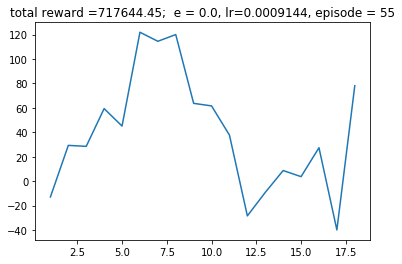

Waiting to train the whole dataset
action0:  46 
action1:  405 
action2:  1499
DONE, lets roll!!
422.523
More than 80 on candle 110
More than 80 on candle 386
More than 80 on candle 589
More than 80 on candle 1941


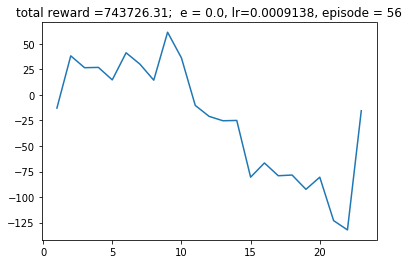

Waiting to train the whole dataset
action0:  40 
action1:  608 
action2:  1302
DONE, lets roll!!
352.478
More than 80 on candle 150
More than 80 on candle 406
More than 80 on candle 576
More than 80 on candle 602
More than 80 on candle 1216
More than 80 on candle 1557
More than 80 on candle 1867


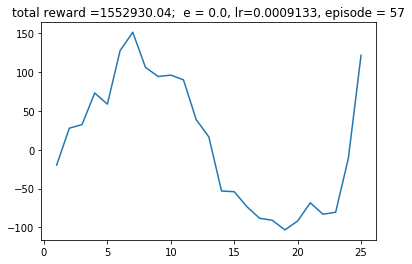

Waiting to train the whole dataset
action0:  24 
action1:  491 
action2:  1435
DONE, lets roll!!
354.492
More than 80 on candle 154
More than 80 on candle 425
More than 80 on candle 908
More than 80 on candle 1870


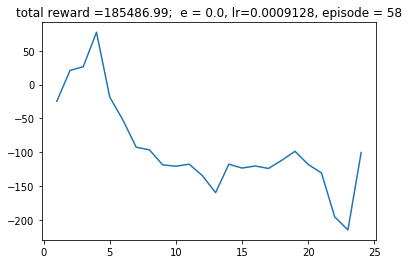

Waiting to train the whole dataset
action0:  23 
action1:  685 
action2:  1242
DONE, lets roll!!
343.204
More than 80 on candle 400
More than 80 on candle 581
More than 80 on candle 875
More than 80 on candle 1861


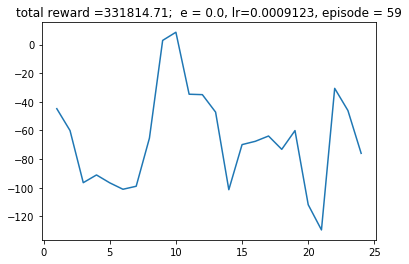

Waiting to train the whole dataset
action0:  34 
action1:  526 
action2:  1390
DONE, lets roll!!
351.242
More than 80 on candle 149
More than 80 on candle 430
More than 80 on candle 1065
More than 80 on candle 1889


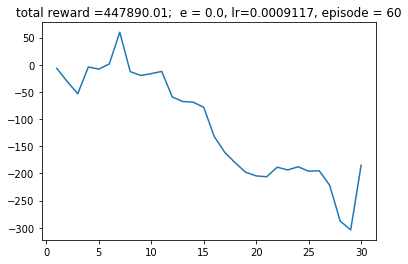

Waiting to train the whole dataset
action0:  40 
action1:  534 
action2:  1376
DONE, lets roll!!
354.059
More than 80 on candle 86
More than 80 on candle 414
More than 80 on candle 973
More than 80 on candle 1079
More than 80 on candle 1849


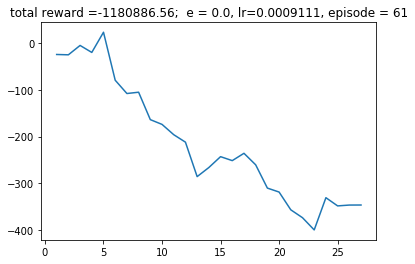

Waiting to train the whole dataset
action0:  37 
action1:  899 
action2:  1014
DONE, lets roll!!
350.061
More than 80 on candle 115
More than 80 on candle 384
More than 80 on candle 560
More than 80 on candle 1924


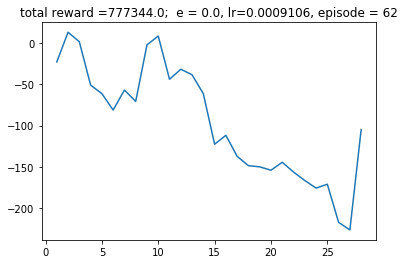

Waiting to train the whole dataset
action0:  36 
action1:  689 
action2:  1225
DONE, lets roll!!
349.825
More than 80 on candle 114
More than 80 on candle 425
More than 80 on candle 902
More than 80 on candle 1389
More than 80 on candle 1860


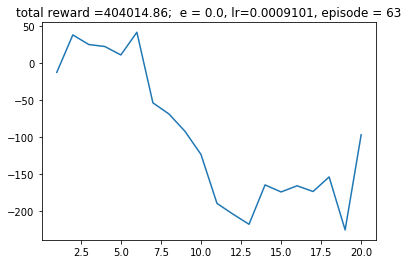

Waiting to train the whole dataset
action0:  27 
action1:  600 
action2:  1323
DONE, lets roll!!
353.38
More than 80 on candle 200
More than 80 on candle 404
More than 80 on candle 474
More than 80 on candle 1390
More than 80 on candle 1875


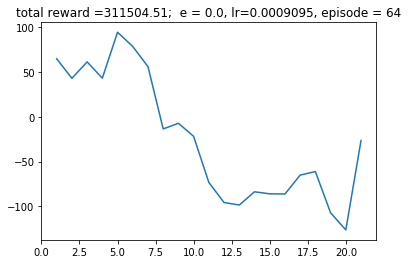

Waiting to train the whole dataset
action0:  43 
action1:  495 
action2:  1412
DONE, lets roll!!
355.109
More than 80 on candle 220
More than 80 on candle 570
More than 80 on candle 1248
More than 80 on candle 1613
More than 80 on candle 1867


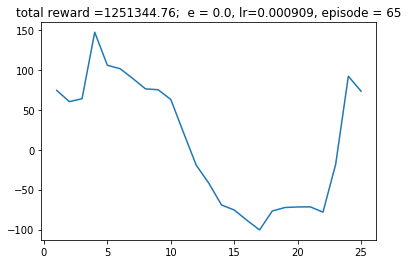

Waiting to train the whole dataset
action0:  50 
action1:  469 
action2:  1431
DONE, lets roll!!
357.0
More than 80 on candle 120
More than 80 on candle 390
More than 80 on candle 574
More than 80 on candle 665
More than 80 on candle 1064
More than 80 on candle 1806


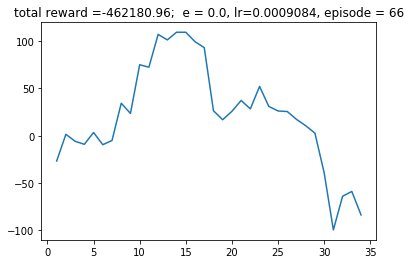

Waiting to train the whole dataset
action0:  55 
action1:  645 
action2:  1250
DONE, lets roll!!
358.395
More than 80 on candle 141
More than 80 on candle 414
More than 80 on candle 1932


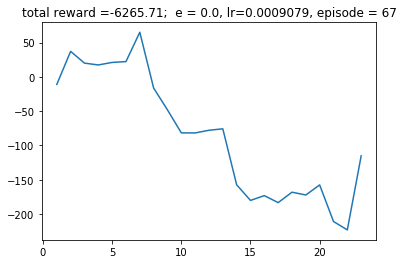

Waiting to train the whole dataset
action0:  13 
action1:  531 
action2:  1406
DONE, lets roll!!
347.851
More than 80 on candle 199
More than 80 on candle 389
More than 80 on candle 603
More than 80 on candle 993
More than 80 on candle 1883


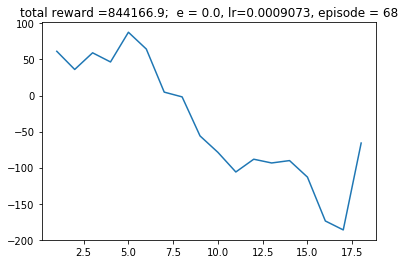

Waiting to train the whole dataset
action0:  4 
action1:  546 
action2:  1400
DONE, lets roll!!
352.24
More than 80 on candle 99
More than 80 on candle 414
More than 80 on candle 576
More than 80 on candle 806
More than 80 on candle 875
More than 80 on candle 1886


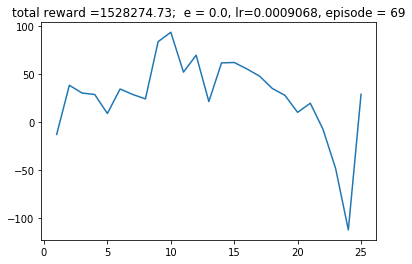

Waiting to train the whole dataset
action0:  42 
action1:  524 
action2:  1384
DONE, lets roll!!
359.556
More than 80 on candle 92
More than 80 on candle 175
More than 80 on candle 219
More than 80 on candle 565
More than 80 on candle 1077
More than 80 on candle 1868


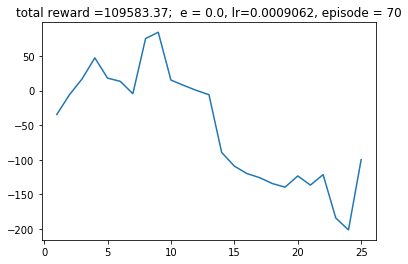

Waiting to train the whole dataset
action0:  24 
action1:  733 
action2:  1193
DONE, lets roll!!
349.701
More than 80 on candle 149
More than 80 on candle 176
More than 80 on candle 426
More than 80 on candle 910
More than 80 on candle 1596
More than 80 on candle 1895


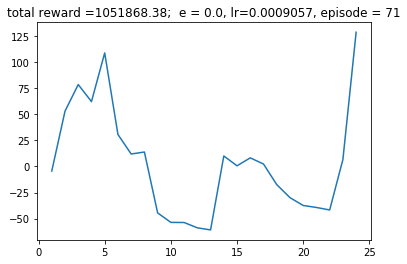

Waiting to train the whole dataset
action0:  33 
action1:  754 
action2:  1163
DONE, lets roll!!
358.736
More than 80 on candle 411
More than 80 on candle 578
More than 80 on candle 1554
More than 80 on candle 1869


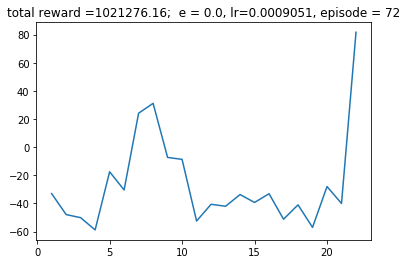

Waiting to train the whole dataset
action0:  35 
action1:  692 
action2:  1223
DONE, lets roll!!
354.477
More than 80 on candle 113
More than 80 on candle 383
More than 80 on candle 917
More than 80 on candle 1091
More than 80 on candle 1502
More than 80 on candle 1877


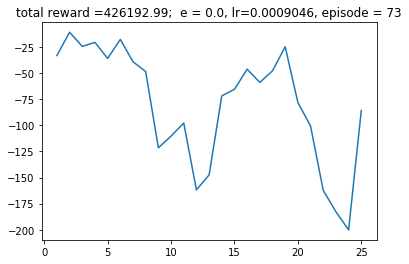

Waiting to train the whole dataset
action0:  22 
action1:  880 
action2:  1048
DONE, lets roll!!
359.611
More than 80 on candle 122
More than 80 on candle 411
More than 80 on candle 571
More than 80 on candle 1432
More than 80 on candle 1942


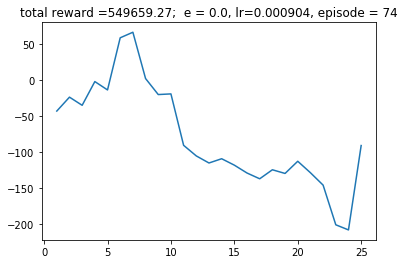

Waiting to train the whole dataset
action0:  33 
action1:  649 
action2:  1268
DONE, lets roll!!
356.84
More than 80 on candle 214
More than 80 on candle 619
More than 80 on candle 746
More than 80 on candle 918
More than 80 on candle 1860


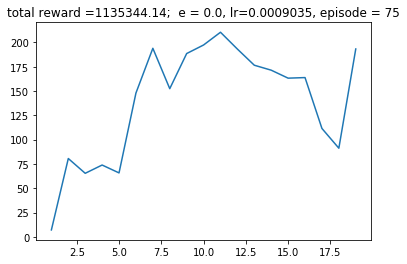

Waiting to train the whole dataset
action0:  18 
action1:  618 
action2:  1314
DONE, lets roll!!
358.025
More than 80 on candle 115
More than 80 on candle 420
More than 80 on candle 908


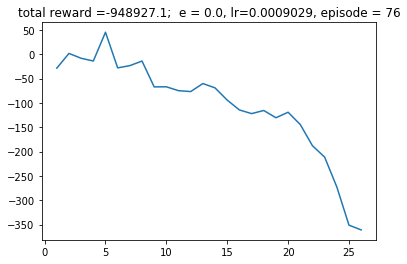

Waiting to train the whole dataset
action0:  37 
action1:  856 
action2:  1057
DONE, lets roll!!
348.064
More than 80 on candle 220
More than 80 on candle 400
More than 80 on candle 587
More than 80 on candle 756
More than 80 on candle 874
More than 80 on candle 1873


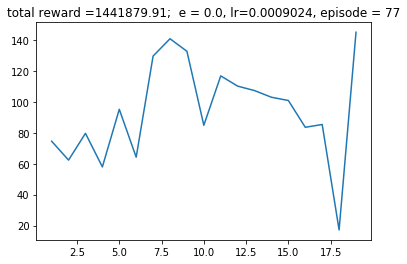

Waiting to train the whole dataset
action0:  19 
action1:  537 
action2:  1394
DONE, lets roll!!
361.112
More than 80 on candle 120
More than 80 on candle 390
More than 80 on candle 576
More than 80 on candle 1223
More than 80 on candle 1601
More than 80 on candle 1849


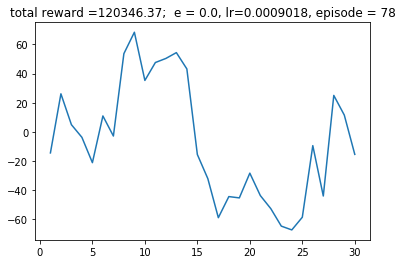

Waiting to train the whole dataset
action0:  22 
action1:  769 
action2:  1159
DONE, lets roll!!
357.964
More than 80 on candle 167
More than 80 on candle 385
More than 80 on candle 605
More than 80 on candle 734
More than 80 on candle 1244
More than 80 on candle 1877


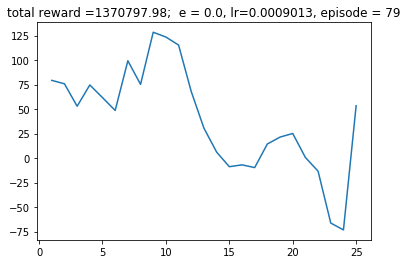

Waiting to train the whole dataset
action0:  44 
action1:  541 
action2:  1365
DONE, lets roll!!
354.721
More than 80 on candle 399
More than 80 on candle 614
More than 80 on candle 1872


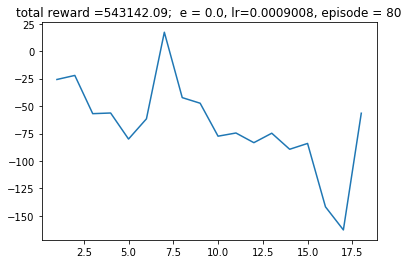

Waiting to train the whole dataset
action0:  44 
action1:  481 
action2:  1425
DONE, lets roll!!
352.34
More than 80 on candle 395
More than 80 on candle 488
More than 80 on candle 1949


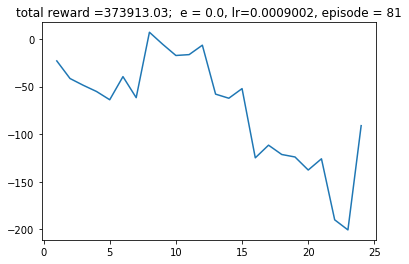

Waiting to train the whole dataset
action0:  32 
action1:  667 
action2:  1251
DONE, lets roll!!
357.216
More than 80 on candle 90
More than 80 on candle 450
More than 80 on candle 1077
More than 80 on candle 1590
More than 80 on candle 1942


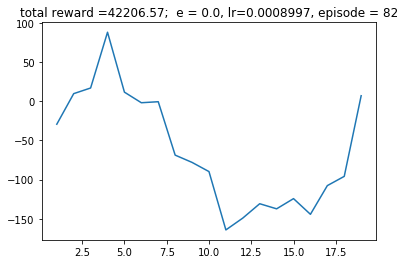

Waiting to train the whole dataset
action0:  37 
action1:  624 
action2:  1289
DONE, lets roll!!
354.754
More than 80 on candle 137
More than 80 on candle 209
More than 80 on candle 396
More than 80 on candle 475
More than 80 on candle 843
More than 80 on candle 875
More than 80 on candle 1921


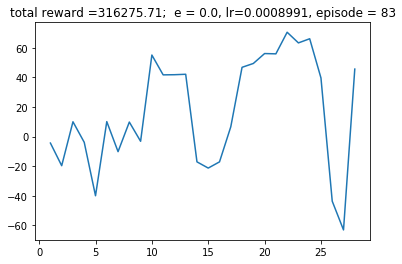

Waiting to train the whole dataset
action0:  48 
action1:  856 
action2:  1046
DONE, lets roll!!
354.364
More than 80 on candle 215
More than 80 on candle 410
More than 80 on candle 598
More than 80 on candle 1075
More than 80 on candle 1807


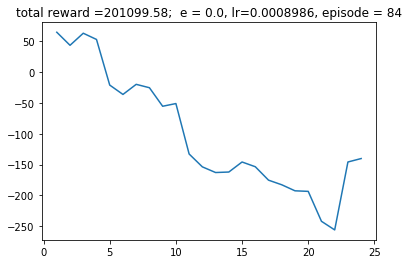

Waiting to train the whole dataset
action0:  19 
action1:  500 
action2:  1431
DONE, lets roll!!
355.776
More than 80 on candle 412
More than 80 on candle 571
More than 80 on candle 1245
More than 80 on candle 1886


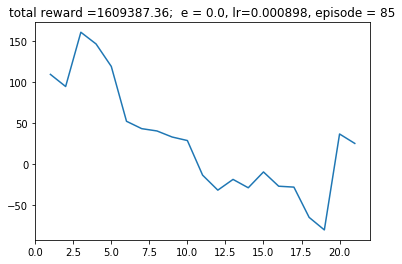

Waiting to train the whole dataset
action0:  29 
action1:  446 
action2:  1475
DONE, lets roll!!
354.832
More than 80 on candle 210
More than 80 on candle 414
More than 80 on candle 912
More than 80 on candle 1077
More than 80 on candle 1377
More than 80 on candle 1861


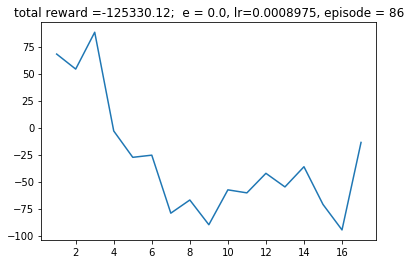

Waiting to train the whole dataset
action0:  11 
action1:  658 
action2:  1281
DONE, lets roll!!
357.771
More than 80 on candle 150
More than 80 on candle 411
More than 80 on candle 580


In [ ]:
env = Trevor(Dataframe())
state_size = (NUMBER_OF_SAMPLES, 9)
action_size = 3
batch_size = 32
agent = DQNAgent(state_size, action_size, batch_size)

#agent.save("./save/cartpole-ddqn.h5")
agent.load("./save/cartpole-ddqn.h5")

closed = False
run = False

for e in range(EPISODES):
    state = env.reset()
    strt = t_lib.time()
    
    akce0 = 0
    akce1 = 0
    akce2 = 0
    
    for time in range(env.df.lenght):
        action, random_action = agent.act(state)

        if action > 3 or action < 0:
            print('Got action ' + action)
            continue

        next_state, reward, closed, _ = env.step(action)

        if not isinstance(next_state, np.ndarray) or not(state, np.ndarray):
            print(next_state)
            print('NOT NUMPY!!')
            continue

        agent.memorize(state=state, action=action, reward=reward, next_state=next_state, done=closed)
        state = next_state
        
        """
        print(f'Actual reward = {round(reward, 1)},\t total reward = {round(env.total_reward, 1)},'
              f'\t action = {action}, \t trade_counter = {round(env.trade_counter, 1)}, '
              f'\t pip_counter = {round(env.closed_counter, 1)}'
              f'\t random_action = {random_action}'
              f'\t candle_number = {time}')
        """
        if action == 0:
            akce0 += 1
        if action == 1:
            akce1 += 1
        if action == 2:
            akce2 += 1
        
        # print("Actual reward = {}\t, total reward = {},\t action = {}\t trade_counter = {}\t pip_counter = {}".format(round(reward, 1), round(env.total_reward, 1), action, round(env.trade_counter, 1), round(env.closed_counter, 1)))
        if closed and reward > 80 * TIMES_FACTOR:
            agent.update_target_model()
            """
            print("episode: {}/{}, score: {}, e: {}, lr: {}"
                  .format(e, EPISODES, time, round(agent.epsilon, 2)), round(agent.learning_rate, 2))
            """
            print('More than 80 on candle {}'.format(time))
        
        if len(agent.memory) > batch_size:
            # agent.replay(batch_size)
            if not run:
                thr_list = [Thread(target=agent.replay) for _ in range(1)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                    
                thr_list = [Thread(target=agent.train_from_iterations) for _ in range(4)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                
                run = True
                
    # clear_output()
    env.plot(title='total reward ={};  e = {}, lr={}, episode = {}'.format(round(env.total_reward, 2), round(agent.epsilon, 4), round(agent.learning_rate, 7), e))
    env.reset_closed_list()
    print('Waiting to train the whole dataset')
    print("action0: ", akce0,"\naction1: ", akce1,"\naction2: ", akce2)
    while not len(agent.sample_memory) == 0:
        pass
    agent.set_learning_rate()
    print('DONE, lets roll!!')
    agent.save("./save/cartpole-ddqn.h5")
    print(round(t_lib.time() - strt, 3))